In [47]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import acquire_r
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk

In [97]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [315]:
# List of urls to scrape
g_url = ['https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=forks&type=Repositories', ' https://github.com/search?o=desc&p=2&q=stars%3A%3E1&s=forks&type=Repositories'\
         'https://github.com/search?o=desc&p=3&q=stars%3A%3E1&s=forks&type=Repositories', 'https://github.com/search?o=desc&p=4&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=5&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=6&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=7&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=8&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=9&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=10&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=11&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=12&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=13&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=14&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=15&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=16&q=stars%3A%3E1&s=forks&type=Repositories',
        'https://github.com/search?o=desc&p=17&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=18&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=19&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=20&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=21&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=22&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=23&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=24&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=25&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=26&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=27&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=28&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=29&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=30&q=stars%3A%3E1&s=forks&type=Repositories']

In [316]:
def get_repos(urls):
    repo = []
    for url in urls:
        time.sleep(10)
        response = get(url, headers=headers)
        soup = BeautifulSoup(response.text)
        text = soup.find_all(attrs={"f4 text-normal"})
        for i in text:
            repo.append(i.find('a')['href'])
    return repo

In [317]:
repos = get_repos(g_url)

In [323]:
# list = []
# for repo in repos:
#     list.append(repo[1:])
    

In [92]:
#repos = scraper.get_repos(g_url)

/Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py:28: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 28 of the file /Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [457]:
f = open('data2.json')
json_file = json.load(f)

In [458]:
df = pd.DataFrame(json_file)

In [459]:
df

,repo,language,readme_contents
0,jtleek/datasharing,None,How to share data with a statistician\n=======...
1,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...
2,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...
3,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www...."
4,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...
...,...,...,...
275,google-research/bert,Python,"# BERT\n\n**\*\*\*\*\* New March 11th, 2020: S..."
276,apache/hadoop,Java,"For the latest information about Hadoop, pleas..."
277,learn-co-students/js-functions-lab-bootcamp-pr...,JavaScript,# JavaScript Functions\n\n## Objectives\n\n1. ...
278,OAI/OpenAPI-Specification,None,# The OpenAPI Specification\n\n[![Build Status...


In [460]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             280 non-null    object
 1   language         245 non-null    object
 2   readme_contents  280 non-null    object
dtypes: object(3)
memory usage: 6.7+ KB


In [461]:
df.isnull().sum()

repo                0
language           35
readme_contents     0
dtype: int64

In [462]:
df = df.dropna(axis =0)

In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 1 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             245 non-null    object
 1   language         245 non-null    object
 2   readme_contents  245 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


In [464]:
df = df.reset_index(drop = True)

In [465]:
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
HTML                12
Jupyter Notebook    12
Go                  11
PHP                 11
TypeScript          10
Ruby                 9
C                    8
CSS                  8
Shell                5
Vue                  3
C#                   2
Kotlin               2
R                    2
Rust                 2
TeX                  2
PowerShell           2
Swift                1
ApacheConf           1
Dart                 1
Scala                1
Objective-C          1
Groovy               1
Name: language, dtype: int64

In [466]:
df['language'] = df.language.replace(['PHP','Shell','Kotlin','Vue','ApacheConf','Jupyter Notebook','R','Groovy',\
                                      'Kotlin','Scala','Rust', 'Swift','C#','Dart','Ruby','Objective-C','PowerShell','TeX' ], 'Other')

In [468]:
df = df[df.language != 'Other']

In [469]:
df.language.value_counts()

JavaScript    58
Java          33
Python        31
C++           16
HTML          12
Go            11
TypeScript    10
CSS            8
C              8
Name: language, dtype: int64

In [470]:
df['language'] = df.language.replace(['C', 'CSS', 'TypeScript', 'Go' ], 'Other')

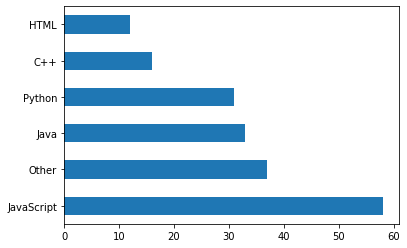

In [471]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh()

In [472]:
df = df.drop(columns = ['repo'])

In [473]:
df.head(4)

,language,readme_contents
1,HTML,### Well hello there!\n\nThis repository is me...
2,C++,"<div align=""center"">\n <img src=""https://www...."
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
5,Python,![Logo](https://storage.googleapis.com/model_g...


In [474]:
df = prepare_r.prep_contents(df)

In [475]:
df = df.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])
df.head(4)

,language,readme_contents,cleaned
1,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...
2,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src tensorflow org image ...
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...
5,Python,![Logo](https://storage.googleapis.com/model_g...,logo storage googleapis com model garden artif...


In [476]:
# Train/test split before exploration
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

## Exploration
***

In [362]:
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com               7861
org               1622
library           1063
python             969
img                952
data               905
svg                903
doc                819
api                804
href               796
html               762
code               755
opencollective     737
webpack            734
file               700
dtype: int64

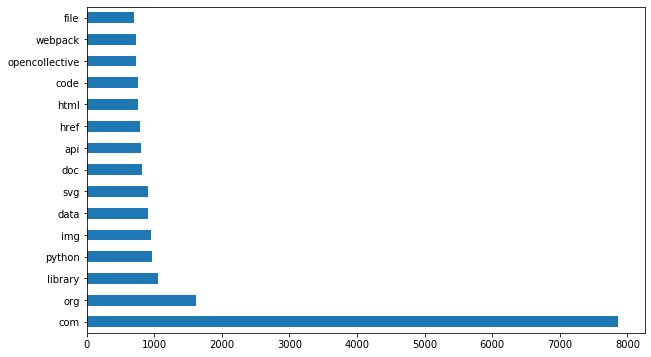

In [363]:
plt.figure(figsize = (10,6))
word_counts.plot.barh()

In [364]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in train.cleaned if word in doc])
    return len(train.cleaned) / n_occurences

In [365]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['align', 'center', 'img', ..., 'languageid', 'smartreply', 'perf'],
      dtype=object)

In [366]:
# put the unique words into a data frame
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

In [367]:
idf_train.head(10)

,idf
word,
planetpython,149.0
errbot,149.0
dogpile,149.0
dogpilecache,149.0
hermescache,149.0
rbf,149.0
pylibmc,149.0
lericson,149.0
libmemcached,149.0


Text(0.5, 0, 'IDF value')

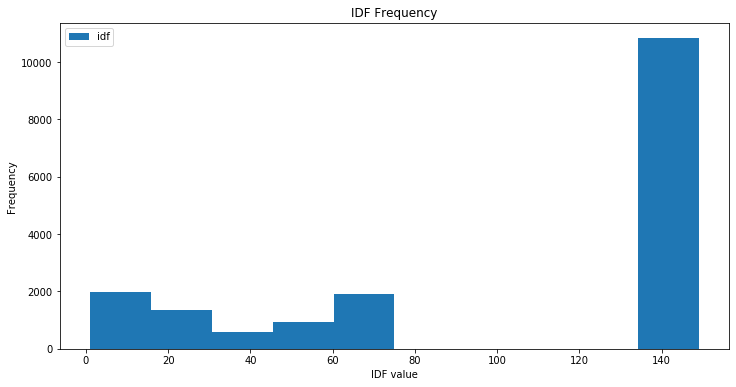

In [368]:
idf_train.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')


In [369]:
# here we create a new column with number of words for each readme file.
train['readme_words'] = train['cleaned'].apply(lambda x: len(x.split()))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [370]:
train

,language,readme_contents,cleaned,readme_words
101,JavaScript,"<p align=""center"">\n <img src=""https://www....",align center img src chartjs org medium logo t...,222
36,JavaScript,# Create React App [![Build Status](https://de...,create react app build status dev azure com fa...,1004
16,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner amazonaws com f...,986
74,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...,75
223,Java,"<p align=""center"">\n\t<img src=""http://content...",align center img src content arduino brand ard...,324
...,...,...,...,...
237,JavaScript,![](https://lh4.googleusercontent.com/-PVw-ZUM...,googleusercontent com pvw zum uuweh aaaaaaaad ...,6868
224,JavaScript,# axios\n\n[![npm version](https://img.shields...,axios npm version img shield npm axios svg sty...,2177
115,C++,# PX4 Drone Autopilot\n\n[![Releases](https://...,drone autopilot release img shield release fir...,641
211,C,FFmpeg README\n=============\n\nFFmpeg is a co...,ffmpeg readme ffmpeg collection library tool p...,163


(0, 10000)

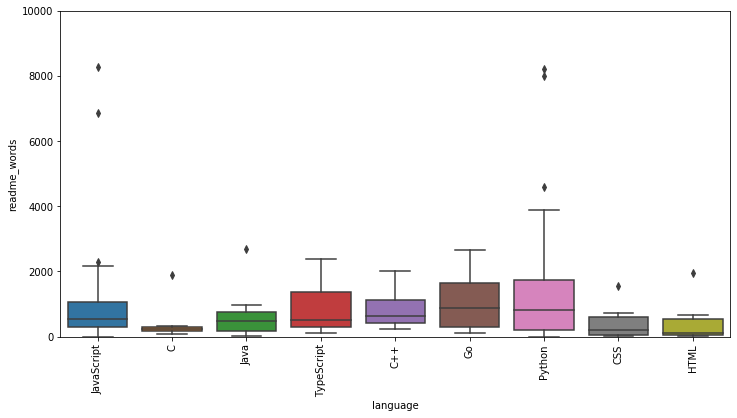

In [371]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,10000)

(0, 2000)

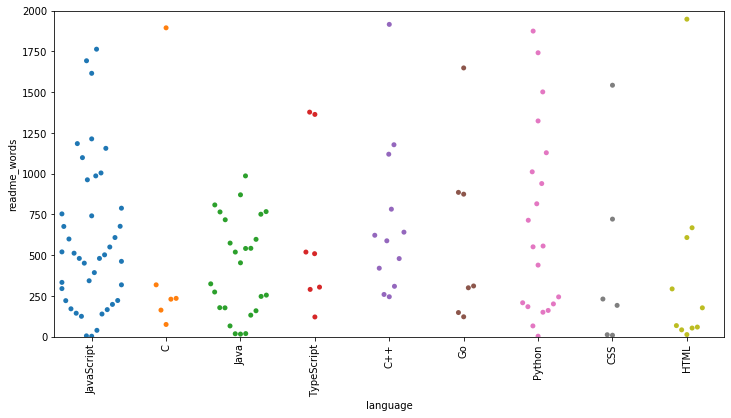

In [372]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,2000)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread

In [378]:
# Next lets explore which words appear most often in a particular language
train.language.value_counts()

JavaScript    46
Java          26
Python        25
C++           13
HTML          10
Go             9
TypeScript     8
C              6
CSS            6
Name: language, dtype: int64

In [379]:
All_words = pd.Series(' '.join(train.cleaned).split()).value_counts()
JavaScript_words = pd.Series(' '.join(train[train.language == 'JavaScript'].cleaned).split()).value_counts()
Other_words = pd.Series(' '.join(train[train.language == 'Other'].cleaned).split()).value_counts()
Python_words = pd.Series(' '.join(train[train.language == 'Python'].cleaned).split()).value_counts()
java_words = pd.Series(' '.join(train[train.language == 'Java'].cleaned).split()).value_counts()
TypeScript_words = pd.Series(' '.join(train[train.language == 'TypeScript'].cleaned).split()).value_counts()
Cplus_words = pd.Series(' '.join(train[train.language == 'C++'].cleaned).split()).value_counts()
CSS_words = pd.Series(' '.join(train[train.language == 'CSS'].cleaned).split()).value_counts()
HTML_words = pd.Series(' '.join(train[train.language == 'HTML'].cleaned).split()).value_counts()
C_words = pd.Series(' '.join(train[train.language == 'C'].cleaned).split()).value_counts()
Go_words = pd.Series(' '.join(train[train.language == 'Go'].cleaned).split()).value_counts()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [380]:
word_counts = (pd.concat([All_words, JavaScript_words, Other_words, Python_words,java_words, TypeScript_words, Cplus_words,\
                         CSS_words,HTML_words, C_words, Go_words],\
                         axis=1, sort=True).set_axis(['All','JavaScript', 'Other', 'Python','Java', 'TypeScript', 'C++',\
                         'CSS','HTML', 'C', 'Go_'], axis=1, inplace=False).fillna(0)\
               .apply(lambda s: s.astype(int)))

word_counts.head()

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
aaaaaaaaaac,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaaai,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaad,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaecm,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaerc,1,1,0,0,0,0,0,0,0,0,0


In [381]:
word_counts.sort_values(by='All', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,7861,2215,0,2208,423,279,342,117,125,27,2125
org,1622,524,0,509,123,64,255,17,26,13,91
library,1063,92,0,488,41,8,36,0,1,7,390
python,969,2,0,902,5,0,41,0,1,2,16
img,952,664,0,65,90,78,21,9,9,5,11
data,905,150,0,569,38,13,10,1,4,25,95
svg,903,620,0,59,58,79,46,11,4,7,19
doc,819,268,0,237,107,33,87,15,13,10,49
api,804,135,0,429,41,7,31,0,1,4,156
href,796,758,0,19,9,2,3,0,5,0,0


In [382]:
word_counts.sort_values(by='JavaScript', ascending=False)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,7861,2215,0,2208,423,279,342,117,125,27,2125
href,796,758,0,19,9,2,3,0,5,0,0
webpack,734,715,0,0,0,19,0,0,0,0,0
opencollective,737,714,0,1,14,8,0,0,0,0,0
img,952,664,0,65,90,78,21,9,9,5,11
...,...,...,...,...,...,...,...,...,...,...,...
curitiba,1,0,0,0,0,0,0,0,0,0,1
machinelearn,1,0,0,1,0,0,0,0,0,0,0
machinelearning,10,0,0,10,0,0,0,0,0,0,0
machinelearningmastery,1,0,0,1,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Word cloud for all words')

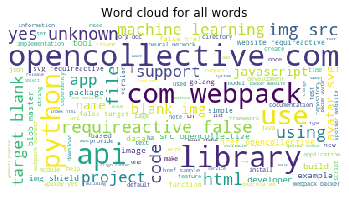

In [383]:
# word cloud for all words
img = WordCloud(background_color='white').generate(' '.join(train.cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Word cloud for all words')

Text(0.5, 1.0, 'Python wordcloud')

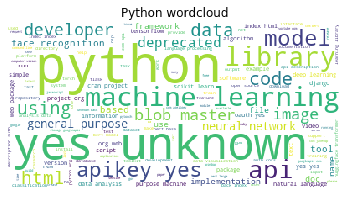

In [384]:
# word cloud for Python
img = WordCloud(background_color='white').generate(' '.join(train[train.language == 'Python'].cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python wordcloud')

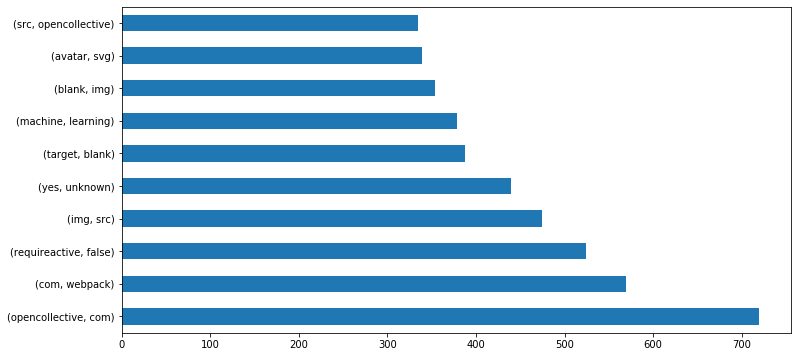

In [385]:
#lets look at bigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 2)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [386]:
top_30_bigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 2)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Bigrams')

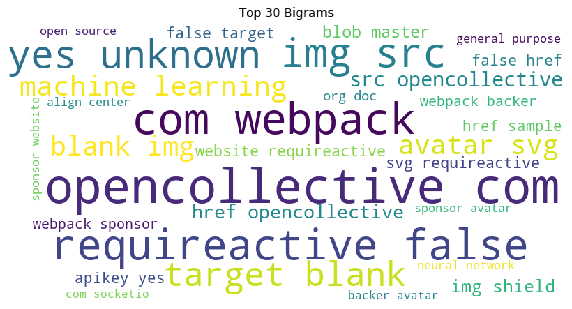

In [387]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Bigrams')

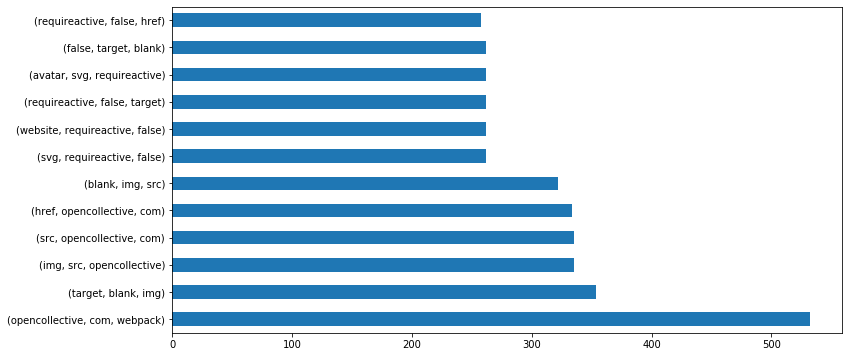

In [388]:
#lets look at trigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 3)
pd.Series(bigrams).value_counts().head(12).plot.barh()

In [389]:
top_30_trigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 3)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Trigrams')

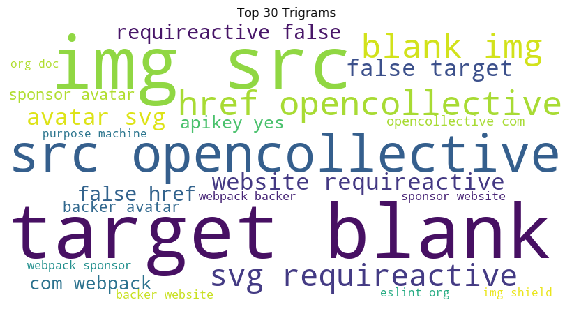

In [390]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Trigrams')

In [391]:
def digits(text):
    digits = len(re.sub("[^0-9]", "", text ))
    return digits    

In [392]:
train['digits'] = train.readme_contents.apply(digits)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [393]:
train

,language,readme_contents,cleaned,readme_words,digits
101,JavaScript,"<p align=""center"">\n <img src=""https://www....",align center img src chartjs org medium logo t...,222,14
36,JavaScript,# Create React App [![Build Status](https://de...,create react app build status dev azure com fa...,1004,161
16,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner amazonaws com f...,986,51
74,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...,75,45
223,Java,"<p align=""center"">\n\t<img src=""http://content...",align center img src content arduino brand ard...,324,2
...,...,...,...,...,...
237,JavaScript,![](https://lh4.googleusercontent.com/-PVw-ZUM...,googleusercontent com pvw zum uuweh aaaaaaaad ...,6868,843
224,JavaScript,# axios\n\n[![npm version](https://img.shields...,axios npm version img shield npm axios svg sty...,2177,219
115,C++,# PX4 Drone Autopilot\n\n[![Releases](https://...,drone autopilot release img shield release fir...,641,150
211,C,FFmpeg README\n=============\n\nFFmpeg is a co...,ffmpeg readme ffmpeg collection library tool p...,163,0


(0, 500)

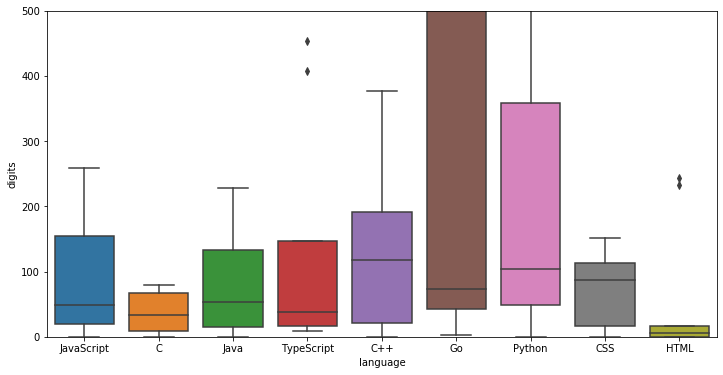

In [394]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'digits', data = train)
plt.ylim(0,500)

## Modeling

In [477]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [478]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [479]:
X_train

<149x21152 sparse matrix of type '<class 'numpy.float64'>'
	with 49501 stored elements in Compressed Sparse Row format>

In [480]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [481]:
lm = LogisticRegression(solver = 'liblinear', C = 2).fit(X_train, y_train)
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [482]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.32%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++          12     0     0           0      0       0
HTML          0     7     0           0      0       0
Java          0     0    26           0      0       0
JavaScript    1     2     0          46      0       0
Other         0     1     0           0     29       0
Python        0     0     0           0      0      25
---
              precision    recall  f1-score   support

         C++       1.00      0.92      0.96        13
        HTML       1.00      0.70      0.82        10
        Java       1.00      1.00      1.00        26
  JavaScript       0.94      1.00      0.97        46
       Other       0.97      1.00      0.98        29
      Python       1.00      1.00      1.00        25

    accuracy                           0.97       149
   macro avg       0.98      0.94      0.96       149
weighted avg       0.97      0

In [483]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 44.74%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          0     0     5           0      0       0
JavaScript    3     2     2          12      7       6
Python        0     0     0           0      1       0
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       1.00      0.71      0.83         7
  JavaScript       0.38      1.00      0.55        12
       Other       0.00      0.00      0.00         8
      Python       0.00      0.00      0.00         6

    accuracy                           0.45        38
   macro avg       0.23      0.29      0.23        38
weighted avg       0.30      0.45      0.33        38



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [490]:
from sklearn.tree import DecisionTreeClassifier
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [491]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 66.44%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       0
Java          0     2    19           1      1       1
JavaScript    1     0     0          32      5       0
Other         4     8     7          13     23       7
Python        0     0     0           0      0      17
---
              precision    recall  f1-score   support

         C++       1.00      0.62      0.76        13
        HTML       0.00      0.00      0.00        10
        Java       0.79      0.73      0.76        26
  JavaScript       0.84      0.70      0.76        46
       Other       0.37      0.79      0.51        29
      Python       1.00      0.68      0.81        25

    accuracy                           0.66       149
   macro avg       0.67      0.59      0.60       149
weighted avg       0.73      0.66      0.67       149



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [492]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 52.63%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           0     0     0           0      1       0
Java          1     0     4           0      1       0
JavaScript    0     0     0           4      0       0
Other         2     2     3           7      6       0
Python        0     0     0           1      0       6
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.67      0.57      0.62         7
  JavaScript       1.00      0.33      0.50        12
       Other       0.30      0.75      0.43         8
      Python       0.86      1.00      0.92         6

    accuracy                           0.53        38
   macro avg       0.47      0.44      0.41        38
weighted avg       0.64      0.53      0.51        38



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
